In [270]:
import matplotlib

%matplotlib notebook
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm_notebook
from sklearn.svm import SVR

import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave

from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
from mayavi import mlab

In [271]:
features_filename = '39-features-v2.xlsx'

In [272]:
df = pd.read_excel(features_filename, index_col=0)

# Histogram

In [273]:
mep_metric = 'mep_category_absolute'

In [274]:
df.head()

,all_all_max_amplitude,all_all_max_power,all_all_max_power_freq,all_alpha_max_amplitude,all_alpha_max_power,all_alpha_max_power_freq,all_beta_max_power,all_beta_max_power_freq,all_delta_max_power,all_delta_max_power_freq,...,wavelet_central_max_power_freq,wavelet_central_max_power_time,wavelet_ltm1_max_power_at_freq,wavelet_ltm1_max_power_at_time,wavelet_ltm1_max_power_freq,wavelet_ltm1_max_power_time,wavelet_rtm1_max_power_at_freq,wavelet_rtm1_max_power_at_time,wavelet_rtm1_max_power_freq,wavelet_rtm1_max_power_time
0,0.000002,2.777808e-16,36,0.000002,1.656928e-16,10,6.341239e-17,26,5.535620e-17,4,...,1699.758956,389.247039,9.290681,-0.203200,795.413564,391.136163,0.976562,-0.260847,920.688314,205.866166
1,0.000002,7.045166e-16,10,0.000002,7.045166e-16,10,3.202701e-16,22,1.251420e-16,2,...,1350.207889,412.348892,11.048543,-0.074716,2749.205329,869.753544,15.625000,-0.341944,874.440057,279.965552
2,0.000002,4.643096e-16,24,0.000002,1.054613e-16,10,4.643096e-16,24,3.785974e-16,4,...,1504.189000,407.994715,2.129898,-0.179751,2413.468286,1359.271661,17.039183,-0.176331,822.499312,317.586076
3,0.000002,6.469294e-16,18,0.000002,6.144056e-16,10,6.469294e-16,18,3.054810e-16,2,...,722.309329,221.358686,18.581361,-0.500718,1147.498869,447.783394,1.953125,-0.117707,846.045450,335.391806
4,0.000002,8.671570e-16,34,0.000002,3.254531e-16,8,7.122134e-16,26,2.245107e-16,2,...,7217.637690,1182.716816,7.812500,-0.102074,1469.422729,698.547856,1.161335,-0.206620,2639.615189,646.149552


In [275]:
channel = 'ltm1'

In [276]:
x = df['wavelet_' + channel + '_max_power_at_freq']
y = df['wavelet_' + channel + '_max_power_freq']
z = df[mep_metric]

In [277]:
print(x.shape)
print(y.shape)
print(z.shape)

(1400,)
(1400,)
(1400,)


In [278]:
import seaborn as sns

In [279]:
df2 = df
df2['power_group'] = pd.cut(df2['wavelet_'+channel+'_max_power_freq'], np.linspace(0, 14000, 100))
df2['power_group'] = df2['power_group'].astype(str)
df2 = df2.pivot_table(mep_metric, index='power_group', columns='wavelet_' + channel + '_max_power_at_freq', aggfunc=np.max)

In [280]:
df2.head()

wavelet_ltm1_max_power_at_freq,2.129897915361832,2.32267014648969,2.532889755177753,2.762135864009951,3.012130518374884,3.284751622084823,3.582047043768247,3.90625,4.259795830723664,4.645340292979379,...,10.13155902071101,11.04854345603981,12.04852207349954,13.13900648833929,14.32818817507299,15.625,17.03918332289465,18.58136117191752,20.26311804142203,31.25
power_group,,,,,,,,,,,,,,,,,,,,,
"(0.0, 141.414]",2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,...,2.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(10040.404, 10181.818]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(10888.889, 11030.303]",NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(1131.313, 1272.727]",2.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN
"(11737.374, 11878.788]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [281]:
df2.shape

(56, 28)

<IPython.core.display.Javascript object>


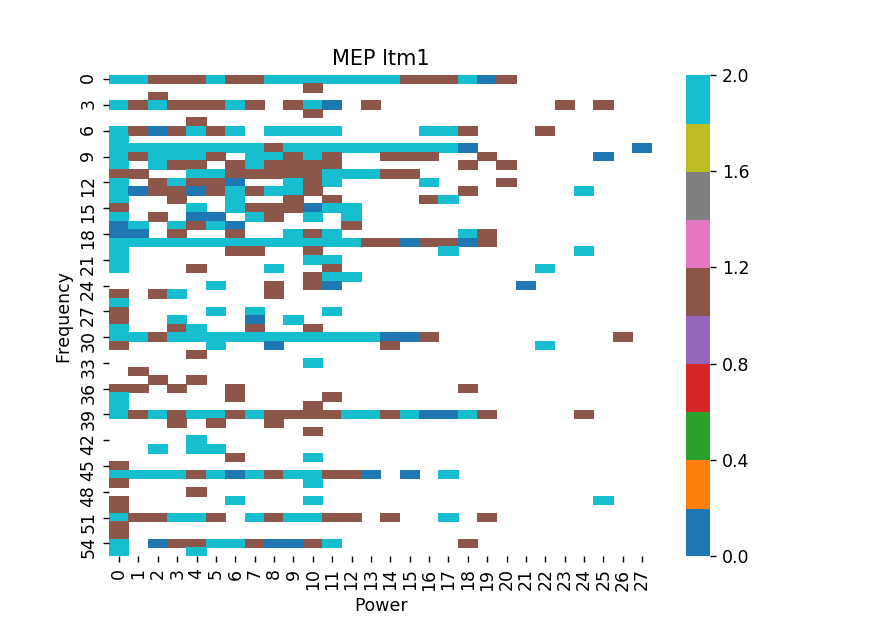

In [282]:
plt.figure(figsize=(7,5))
ax = sns.heatmap(df2.values, cmap='tab10', robust=True)
ax.set_xlabel('Power')
ax.set_ylabel('Frequency')
ax.set_title('MEP ' + channel)
plt.show()

In [283]:
# df2 = df[df[mep_metric] == 0]
# df2['power_group'] = pd.cut(df2['wavelet_' + channel + '_max_power_freq'], np.linspace(0, 14000, 100))    
# df2['power_group_left'] = df2['power_group'].apply(lambda x: x.left)
# df2['power_group'] = df2['power_group'].astype(str)

# power_group_map = pd.DataFrame()
# power_group_map['power_group_left'] = df2['power_group_left']
# power_group_map['power_group'] = df2['power_group']

# df2 = df2.groupby(['power_group_left', 'wavelet_'+channel+'_max_power_at_freq']).count()
# df2 = df2.pivot_table(mep_metric, index='power_group_left', columns='wavelet_' + channel + '_max_power_at_freq', aggfunc='sum')

# # df2.set_index(df2.index.apply(lambda x: df3))

# power_group_map = power_group_map.set_index('power_group_left')
# power_group_map.head()

# power_group_map.loc[[1838.384]]
# df2.head(5)
# df3 = df2
# df3.sort_index()
# df3.tail()

# power_group = []
# for idx, row in df3.iterrows():
#     print(idx)
#     print(power_group_map.loc[[idx]].values[0].astype(str))
# #     df2.append(power_group_map.loc[[row]])

In [289]:
df2 = df[df[mep_metric] == 0]
df2['power_group'] = pd.cut(df2['wavelet_'+channel+'_max_power_freq'], np.linspace(0, 14000, 100))
df2['power_group_left'] = df2['power_group'].apply(lambda x: x.left)
df2 = df2.groupby(['power_group_left', 'wavelet_'+channel+'_max_power_at_freq']).count()
df2 = df2.pivot_table(mep_metric, index='power_group_left', columns='wavelet_' + channel + '_max_power_at_freq', aggfunc='sum')
df2.tail()

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


all_all_max_amplitude  \
power_group_left wavelet_ltm1_max_power_at_freq                          
13858.586        10.131559                                         NaN   
                 11.048543                                         NaN   
                 13.139006                                         NaN   
                 18.581361                                         NaN   
                 31.250000                                         NaN   

                                                 all_all_max_power  \
power_group_left wavelet_ltm1_max_power_at_freq                      
13858.586        10.131559                                     NaN   
                 11.048543                                     NaN   
                 13.139006                                     NaN   
                 18.581361                                     NaN   
                 31.250000                                     NaN   

                                                 all_all_max_power_freq  \
power_group_left wavelet_ltm1_max_power_at_freq                           
13858.586        10.131559                                          NaN   
                 11.048543                                          NaN   
                 13.139006                                          NaN   
                 18.581361                                          NaN   
                 31.250000                                          NaN   

                                                 all_alpha_max_amplitude  \
power_group_left wavelet_ltm1_max_power_at_freq                            
13858.586        10.131559                                           NaN   
                 11.048543                                           NaN   
                 13.139006                                           NaN   
                 18.581361                                           NaN   
                 31.250000                                           NaN   

                                                 all_alpha_max_power  \
power_group_left wavelet_ltm1_max_power_at_freq                        
13858.586        10.131559                                       NaN   
                 11.048543                                       NaN   
                 13.139006                                       NaN   
                 18.581361                                       NaN   
                 31.250000                                       NaN   

                                                 all_alpha_max_power_freq  \
power_group_left wavelet_ltm1_max_power_at_freq                             
13858.586        10.131559                                            NaN   
                 11.048543                                            NaN   
                 13.139006                                            NaN   
                 18.581361                                            NaN   
                 31.250000                                            NaN   

                                                 all_beta_max_power  \
power_group_left wavelet_ltm1_max_power_at_freq                       
13858.586        10.131559                                      NaN   
                 11.048543                                      NaN   
                 13.139006                                      NaN   
                 18.581361                                      NaN   
                 31.250000                                      NaN   

                                                 all_beta_max_power_freq  \
power_group_left wavelet_ltm1_max_power_at_freq                            
13858.586        10.131559                                           NaN   
                 11.048543                                           NaN   
                 13.139006                                           NaN   
                 18.581361                               

In [305]:
def plot_heatmap(df2, title):
    title = title + ' - ' + str(df2.shape[0]) + ' MEPs'
    df2['power_group'] = pd.cut(df2['wavelet_'+channel+'_max_power_freq'], np.linspace(0, 14000, 100))
    df2['power_group_left'] = df2['power_group'].apply(lambda x: x.left)
    df2 = df2.groupby(['power_group_left', 'wavelet_'+channel+'_max_power_at_freq']).count()
    df2 = df2.pivot_table(mep_metric, index='power_group_left', columns='wavelet_' + channel + '_max_power_at_freq', aggfunc='sum')
    df2 = df2.sort_index(axis=1)
    df2 = df2.sort_index(axis=0)
    plt.figure(figsize=(9,8))
    ax = sns.heatmap(df2.values, cmap='viridis', robust=True, xticklabels=df2.columns, yticklabels=df2.index)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Power')
    ax.set_title(title)
    plt.show()

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


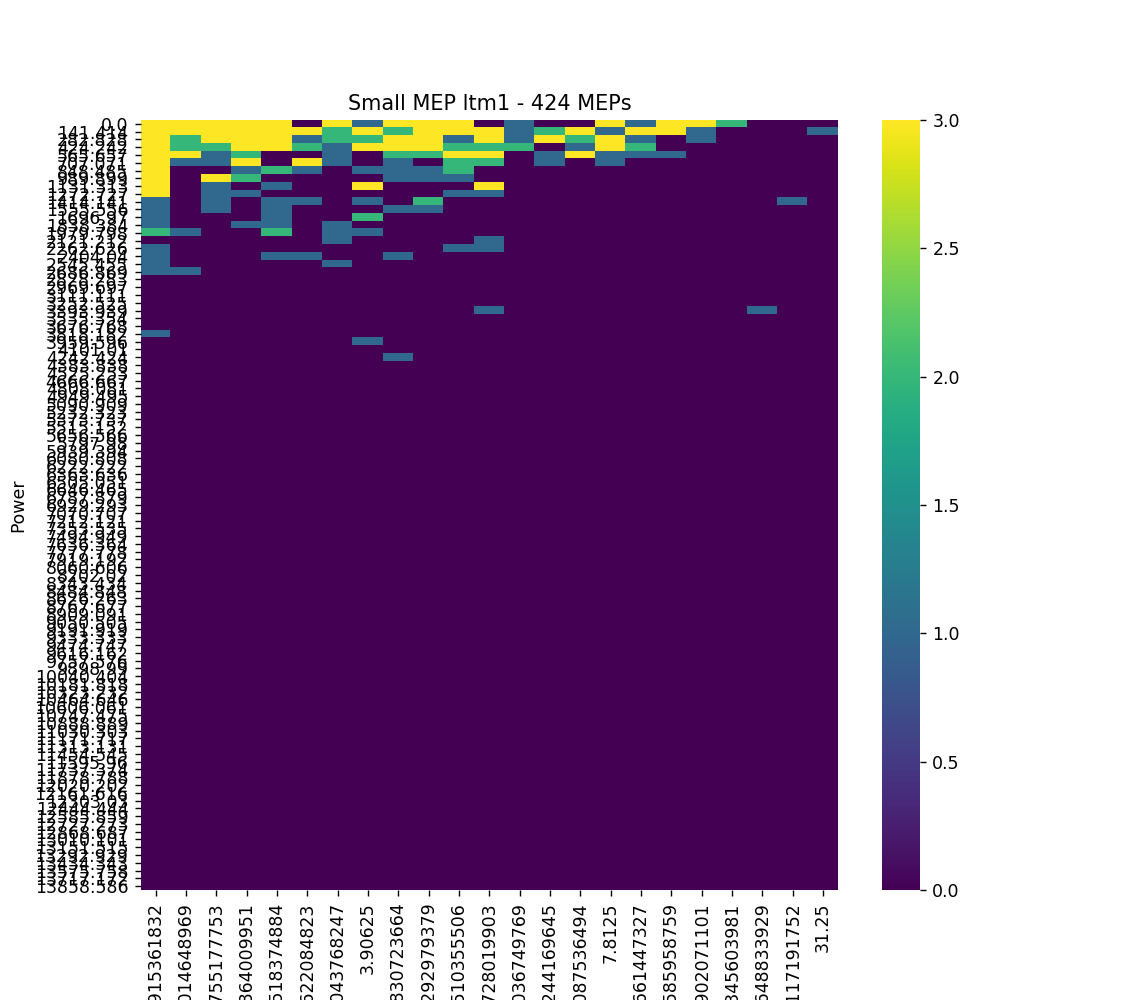

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


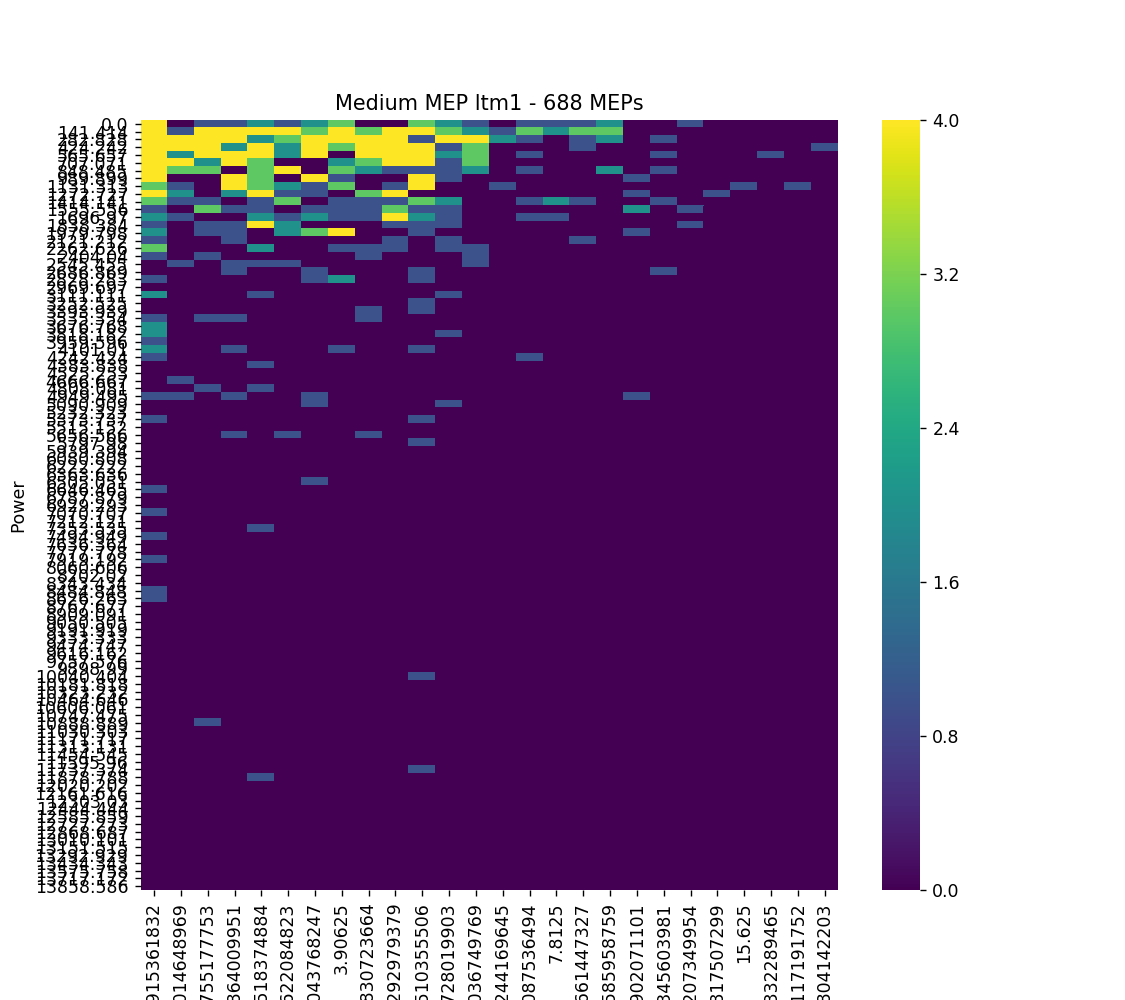

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


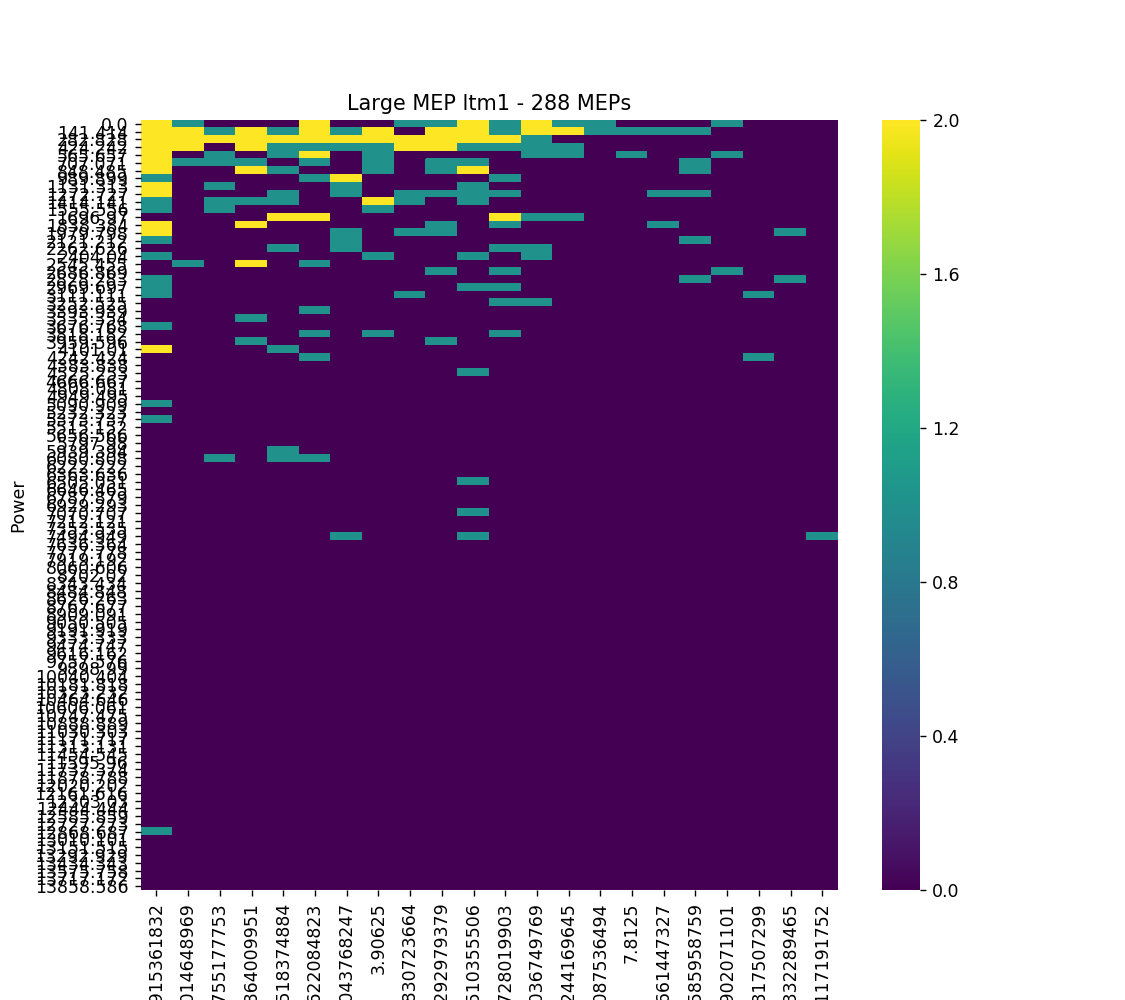

In [306]:
plot_heatmap(df[df[mep_metric] == 0], 'Small MEP ' + channel)
plot_heatmap(df[df[mep_metric] == 1], 'Medium MEP ' + channel)
plot_heatmap(df[df[mep_metric] == 2], 'Large MEP ' + channel)